In [132]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np
from keras.models import load_model
# import pytesseract
import math
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np


def PredictImg(img):
    # 載入模型
    #縮放圖片大小
    Max_Width=20
    Max_Hight=20
    x_test = []
    # for img in imgs:
    try:
        img = cv2.resize(img, (Max_Width, Max_Hight), interpolation=cv2.INTER_CUBIC)
    except:
        return None
    x_test.append(img)
    x_test = np.array(x_test)
    x_test = x_test.reshape(x_test.shape[0], Max_Width, Max_Hight, 1)
    x_test = 255 - x_test
    x_test = x_test.astype('float32')
    x_test /= 255
    pred = model.predict(x_test,batch_size = 25)
    outdict = ['0','1','2','3','4','5','6','7','8','9']
    pred_result = outdict[np.argmax(pred)]
    return pred_result

#去除掉圖片的雜訊，使用filter來決定可不可以用
def ImageFilter(width,height):
    # 面積太小就算雜訊
    if width<=3 or width>20 or width*height<70 \
        or width*height>400 or height <= 14 or height > 22 or height - width < 5:
        return False 
    else:
        return True

def boundleSort(contours,columnLength,rowsLength):
    # sortPatten = {x:0,y:1}
    # sort = [x,y]
    #做Y軸排序
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])

    boundle = []
    boundles = []

    offset = (0,0)
    for i in range(0,len(contours)):  
        x, y, width, height = cv2.boundingRect(contours[i])  
        # 面積太小就算雜訊
        if ImageFilter(width, height) == False:
            continue
        # print (x, y, width, height)
        #把符合規則的邊界存起來
        boundle.append([x, y, width, height])


    #list 分群
    splitRows = [boundle[i:i+columnLength] for i in range(0,len(boundle),columnLength)]
    for bound in splitRows:
        #使用Ｘ軸來排序
        boundles.append(sorted(bound, key=lambda bound: bound[0]))
    return boundles
def DrawBoundle(boundle,img,columnLength):
    for i in range(0,len(boundle)):
        for j in range(len(boundle[i])):
            x, y, width, height = boundle[i][j]
            cv2.rectangle(img, (x, y),
                                        (x + width, 
                                        y + height), (153,153,0), 2) 
            cv2.putText(img, str((i*columnLength)+j), (x,y), cv2.FONT_HERSHEY_SIMPLEX,
                0.2, (0, 255, 255), 1, cv2.LINE_AA)
    return img
def imageProcess(img,THRESH_BINARY_TYPE,threshValue,area,columnLength,rowsLength):
    plt.imshow(img)
    plt.title('original picture')
    plt.show()



    #切割掉不重要的區域
    crop_img = img.crop(area)
    
    plt.imshow(crop_img)
    plt.title('crop_img picture')
    plt.show()


    img = cv2.cvtColor(np.asarray(crop_img),cv2.COLOR_RGB2BGR)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    originalImg = img.copy()                              
    originalImg = cv2.GaussianBlur(originalImg, (1,1), 1)

    if THRESH_BINARY_TYPE == "THRESH_BINARY_INV":
        #二值化
        ret,originalImg = cv2.threshold(originalImg,threshValue,255,        
                                        cv2.THRESH_BINARY_INV)
    else:
        #二值化
        ret,originalImg = cv2.threshold(originalImg,threshValue,255,        
                                        cv2.THRESH_BINARY)
    #x軸（橫向）
    #y軸（直向）
    #保存圖像處理好的圖片
    #膨脹
    imageProcessDone = cv2.erode(originalImg, (1,2), iterations = 2)
    plt.imshow(imageProcessDone)
    plt.title('imageProcessDone')
    plt.show()


    secondSplitImg = imageProcessDone.copy()
    #把完全看不到文字只剩下填滿黑色的色塊版本去做輪廓辨識
    secondSplitImg ,Splitcontours,hierarchy = cv2.findContours(secondSplitImg,cv2.RETR_TREE,
                                                    cv2.CHAIN_APPROX_NONE)

    #送去做Boundle排序
    boundle = boundleSort(contours = Splitcontours,columnLength = columnLength,rowsLength = rowsLength)

    secondSplitImg = DrawBoundle(boundle = boundle,img = secondSplitImg ,columnLength = 20)
    plt.imshow(secondSplitImg)
    plt.title("secondSplitImg")
    plt.show()
    return boundle,imageProcessDone

In [115]:

#顯示辨識結果
def showRecognizeResult(img,THRESH_BINARY_TYPE,threshValue,area,columnLength,rowsLength):
    boundle,imageProcessDone = imageProcess(img = img,THRESH_BINARY_TYPE = THRESH_BINARY_TYPE,threshValue = threshValue,area = area,columnLength = columnLength,rowsLength = rowsLength)

    #儲存所有號碼圖的辨識結果
    output = []
    DrawContours = imageProcessDone.copy()
    _originalImg = imageProcessDone.copy()
    for i in range(0,len(boundle)):
        for j in range(len(boundle[i])):
            x, y, width, height = boundle[i][j]
            # 面積太小就算雜訊
            if ImageFilter(width, height) == False:
                continue
            newImage=_originalImg[y:y+height,
                            x:x+width]

            predValue = PredictImg(newImage)
            output.append(predValue)

            input_dir=("cut_image/")
            if not os.path.isdir(input_dir):
                os.makedirs(input_dir)
            cv2.imwrite("./cut_image/{i}_{predValue}.jpg".format(i=str(i),predValue = predValue),newImage) 

            
    # output.reverse()
    #每兩個數字為一組，這樣比較好區分數組
    step = 2
    output = [output[i:i+step] for i in range(0,len(output),step)]
    
    return output

model = load_model('Models/model.h5')


Type:4
4_3.jpg


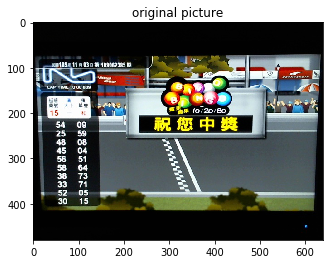

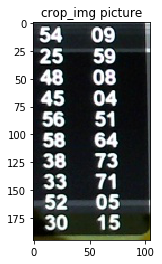

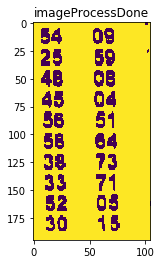

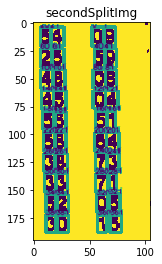

['09', '59', '08', '04', '51', '64', '73', '71', '05', '15']
['54', '25', '46', '45', '56', '56', '38', '33', '52', '30']


In [150]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')

for i in range(4,5):
    print ("Type:" + str(i))
    #圖片要辨識的類型，共八種
    imageType = i

    #x軸（橫向）
    #y軸（直向）
    #讀取切割區域的座標範圍
    _config = config[str(imageType)]
    area = tuple(int(value) for value in _config["area"].split(","))

    #讀取二值化閥值
    threshValue = int(_config["threshValue"])
    #二值化方案（THRESH_BINARY_INV,THRESH_BINARY_INV_INV）
    TYPE = _config["THRESH_BINARY_TYPE"]
    #橫行直列的數量
    columnLength = int(_config["columnLength"])
    rowsLength = int(_config["rowsLength"])


    for j in range(3,4):
        print (str(imageType) + '_{childImage}.jpg'.format(childImage = str(j)))
        img = Image.open(str(imageType) + '_{childImage}.jpg'.format(childImage = str(j)))
        output = showRecognizeResult(img = img,THRESH_BINARY_TYPE = TYPE,threshValue = threshValue,area = area,columnLength = columnLength,rowsLength = rowsLength)
        
        #賽車與套圈圈的數字要做特別處理
        if imageType == 4:
            output.reverse()
            #每兩個數字為一排
            step = 2
            output = [output[i:i+step] for i in range(0,len(output),step)]
            output.reverse()
            outFirstLine = []
            outSecondLine = []
            for ele in output:
                try:    
                    for i in range(len(ele)):
                        #輸出1,3,5,7,9 行，因為數字是直列下來的
                        if i%2 == 1:
                            outSecondLine.append(ele[i][0]+ele[i][1])
                            # print (ele[i][0]+ele[i][1]+",",end='')
                        else:
                            outFirstLine.append(ele[i][0]+ele[i][1])

                except:
                    continue
            print (outFirstLine)
            print (outSecondLine)
        else:
            for ele in output:
                    try:
                        print (ele[0]+ele[1] + "," , end='')
                    except:
                        continue
                